In [1]:
from pathlib import Path

import pandas as pd
import numpy as np

import scipy.stats as sp

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from pylab import savefig

In [2]:
% matplotlib inline

In [3]:
sns.set(style='white')

In [4]:
source_dir = Path().absolute().parents[1] / 'derivatives' / '0.4.joined'

In [5]:
data = pd.read_csv( source_dir / 'all_subject_level.csv' )

In [9]:
data['Condition'] = data['Condition'].map({1:'Annotated',2:'Video',3:'Original'})
data['SciField'] = data['SciField'] - 1
data['Gender'] = data['Gender'] - 1
data['nb_CoR'] = data['nb_CoR']*100
data[['SciEdu_HS','SciEdu_UGrad','SciEdu_Grad']] = data[['SciEdu_HS','SciEdu_UGrad','SciEdu_Grad']].replace({np.nan:0})
data.head()

,sub,Condition,Age,Gender,Major,Major_TEXT,SciDegree,SciDegree_TEXT,EduYears,SciEdu_HS,...,SciLit_sum,SciTudeA_sum,SciTudeL_sum,SciTudeS_sum,O1_sum,O2_sum,O3_sum,O4_sum,O5_sum,O6_sum
0,101,Annotated,20.0,1.0,5.0,biomedical-science,NaN,NaN,14,4,...,4.0,25,21,24,9,14,17,9,12,13
1,102,Video,19.0,1.0,5.0,forensic-science,NaN,NaN,12,3,...,2.0,21,22,26,17,19,14,11,11,9
2,103,Original,18.0,0.0,2.0,communications,NaN,NaN,12,3,...,2.0,27,13,21,16,13,16,10,11,16
3,104,Annotated,18.0,0.0,5.0,statistics,NaN,NaN,12,4,...,2.0,30,20,27,17,13,20,14,15,13
4,105,Video,18.0,0.0,5.0,biomedical-science,NaN,NaN,12,6,...,4.0,21,13,28,17,13,12,12,10,13


# Demographics

In [10]:
df = data.groupby(['AgeGroup','Condition']).agg({
    'sub':'count', 'Age':'mean', 'Gender':'mean', #'SciField':'mean',
})
df.rename(columns={
    'sub':'Count', 'Age':'Mean Age', 'Gender': '% Female'
})

Count   Mean Age  % Female
AgeGroup Condition                            
OA       Annotated     15  71.400000  0.666667
         Original      15  76.466667  0.733333
         Video         18  74.611111  0.611111
YA       Annotated     26  18.500000  0.653846
         Original      27  18.851852  0.518519
         Video         23  19.043478  0.652174

In [11]:
df = data.groupby(['AgeGroup','Condition']).agg({
    'sub':'count', 'comp_change':'mean', 'comp_t1':'mean', 'comp_t2':'mean'
})
df.rename(columns={
    'sub':'Count', 'comp_t1':'T1 comprehension', 'comp_t2':'T2 comprehension', 'comp_change':'Mean Improvement'
})

Count  Mean Improvement  T1 comprehension  \
AgeGroup Condition                                              
OA       Annotated     15          2.333333         11.333333   
         Original      15          3.400000         11.066667   
         Video         18          3.722222         10.555556   
YA       Annotated     26          2.730769         10.576923   
         Original      27          4.111111          9.629630   
         Video         23          3.826087          9.782609   

                    T2 comprehension  
AgeGroup Condition                    
OA       Annotated         13.666667  
         Original          14.466667  
         Video             14.277778  
YA       Annotated         13.307692  
         Original          13.740741  
         Video             13.608696

# Group comparisons

In [12]:
vars_of_interest = ['comp_t1', 'comp_t2', 'comp_change', 'nb_CoR', 'nb_RT', 'procspd_RT',
                    'NFCS_sum','TSSI_sum', 'vocab_sum','SciLit_sum',
                    'SciTudeA_sum','SciTudeL_sum','SciTudeS_sum']

In [13]:
grps_of_interest = ['Condition','AgeGroup',['AgeGroup','Condition']]

# Correlations
We need to drop all missing data listwise. SPSS does this pairwise for the correlations, but I'm not sure how exactly to replicate that. If we find a way to, I would prefer not to destroy data unnecessarily here.

In [14]:
slim_data = data[['sub','AgeGroup','Condition']+vars_of_interest].dropna()

## Correlation Matrices

Define functions to create the correlation & significance tables and matrices

In [15]:
def corr_table(df):
    corr_df = pd.DataFrame()
    for c in vars_of_interest:
        for d in vars_of_interest:
            corr_df.loc[c,d] = sp.pearsonr(df[c],df[d])[0]
    return(corr_df)

def sig_table(df):
    sig_df = pd.DataFrame()
    for c in vars_of_interest:
        for d in vars_of_interest:
            sig_df.loc[c,d] = sp.pearsonr(df[c],df[d])[1]
    return(sig_df)

In [16]:
def matrix_mask(df):
    mask = np.zeros_like(df)
    mask[np.triu_indices_from(mask)] = True
    plt.figure(figsize=(16,5))
    return(mask)

In [17]:
def correlation_matrix(df,title):
    mask = matrix_mask(df)
    fig = sns.heatmap(df, mask=mask, annot=True, cmap='Spectral',
                      fmt='.3f', linewidths=1, center=0)
    fig.set_title(title+'\nCorrelation Coefficients')
    return(fig)

def significance_matrix(df,title):
    mask = matrix_mask(df)
    myColors = (
        (0.4, 0.0, 0.0, 1.00),(0.6, 0.0, 0.0, 0.85),(0.8, 0.0, 0.0, 0.70),(1.0, 0.0, 0.0, 0.55),
        (1.0, 0.0, 0.0, 0.40),(1.0, 0.0, 0.0, 0.40),(1.0, 0.0, 0.0, 0.40),(1.0, 0.0, 0.0, 0.40),
        (1.0, 0.0, 0.0, 0.40),(1.0, 0.0, 0.0, 0.40),(1.0, 0.0, 0.0, 0.40),(1.0, 0.0, 0.0, 0.40),
        (1.0, 0.0, 0.0, 0.40),(1.0, 0.0, 0.0, 0.40),(1.0, 0.0, 0.0, 0.40),(1.0, 0.0, 0.0, 0.40),
        (1.0, 0.0, 0.0, 0.40),(1.0, 0.0, 0.0, 0.40),(1.0, 0.0, 0.0, 0.40),(1.0, 0.0, 0.0, 0.40),
    )
    cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))
    fig = sns.heatmap(df, mask=mask, annot=True, cmap=cmap,
                fmt='.3f', linewidths=1, center=0.5
               )
    fig.set_title(title+'\nCorrelation Significance')
    return(fig)

### All AgeGroups,Conditions

In [18]:
corr_df = corr_table(slim_data)
sig_df = sig_table(slim_data)

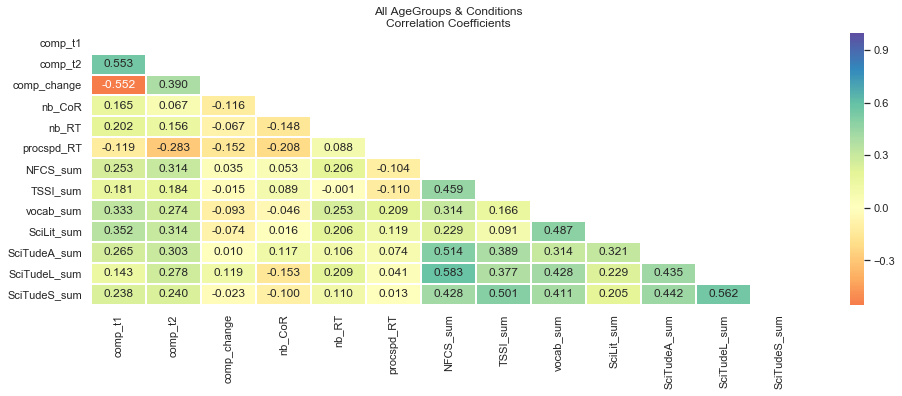

In [19]:
fpath = Path('..') / '..' / 'derivatives' / 'figures' / 'corr_coeff_all.png'
fig = correlation_matrix(corr_df,'All AgeGroups & Conditions')
fig.get_figure().savefig(fpath, bbox_inches='tight')

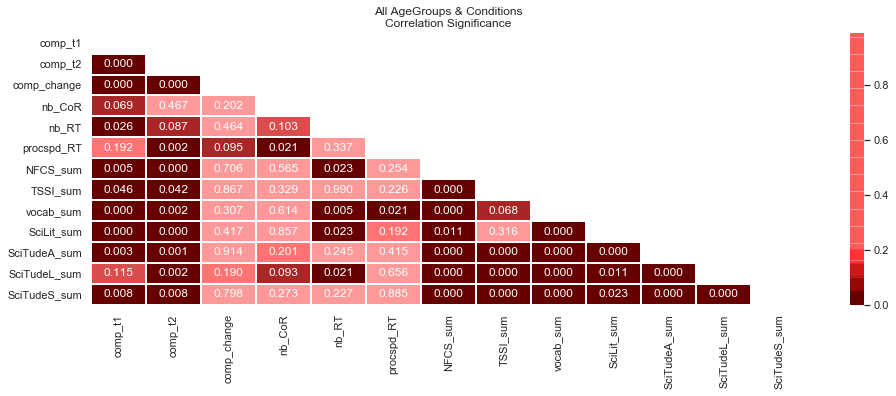

In [20]:
fpath = Path('..') / '..' / 'derivatives' / 'figures' / 'corr_sig_all.png'
fig = significance_matrix(sig_df,'All AgeGroups & Conditions')
fig.get_figure().savefig(fpath, bbox_inches='tight')

### By AgeGroup

In [21]:
ya_data = slim_data[slim_data['AgeGroup'] == 'YA']
oa_data = slim_data[slim_data['AgeGroup'] == 'OA']

In [22]:
ya_corr_df = corr_table(ya_data)
ya_sig_df = sig_table(ya_data)
oa_corr_df = corr_table(oa_data)
oa_sig_df = sig_table(oa_data)

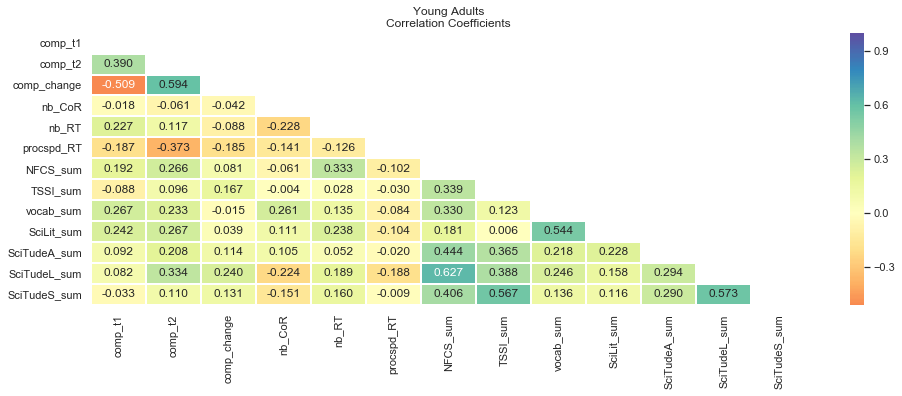

In [23]:
fig = correlation_matrix(ya_corr_df,'Young Adults')
fpath = Path('..') / '..' / 'derivatives' / 'figures' / 'corr_coeff_ya.png'
fig.get_figure().savefig(fpath, bbox_inches='tight')

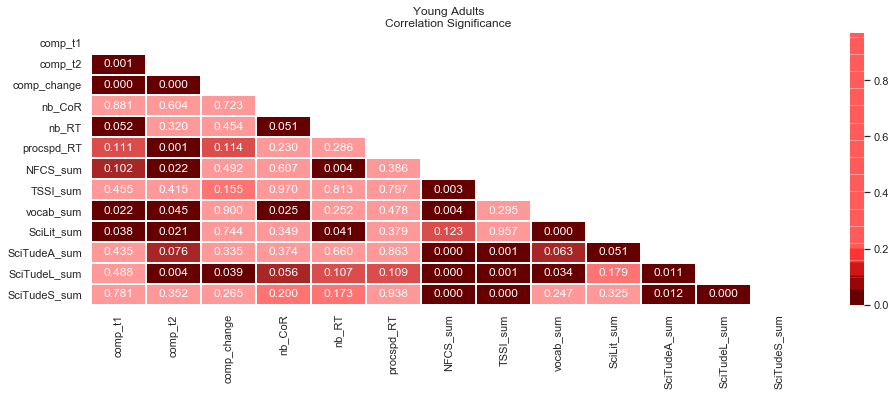

In [24]:
fig = significance_matrix(ya_sig_df,'Young Adults')
fpath = Path('..') / '..' / 'derivatives' / 'figures' / 'corr_sig_ya.png'
fig.get_figure().savefig(fpath, bbox_inches='tight')

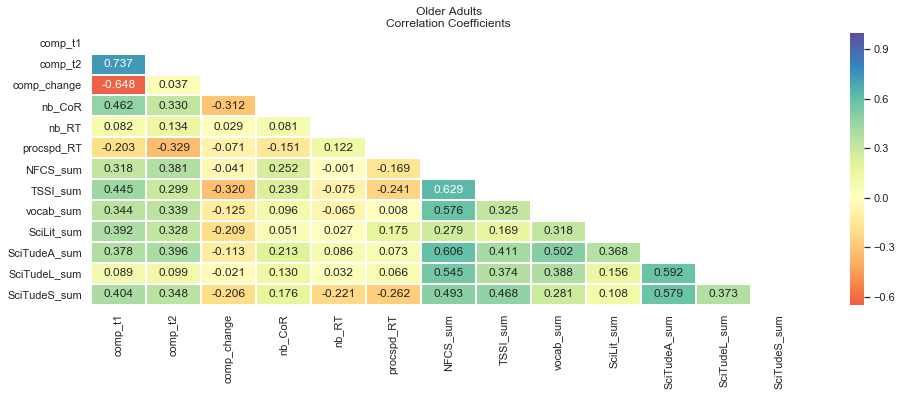

In [25]:
fig = correlation_matrix(oa_corr_df,'Older Adults')
fpath = Path('..') / '..' / 'derivatives' / 'figures' / 'corr_coeff_oa.png'
fig.get_figure().savefig(fpath, bbox_inches='tight')

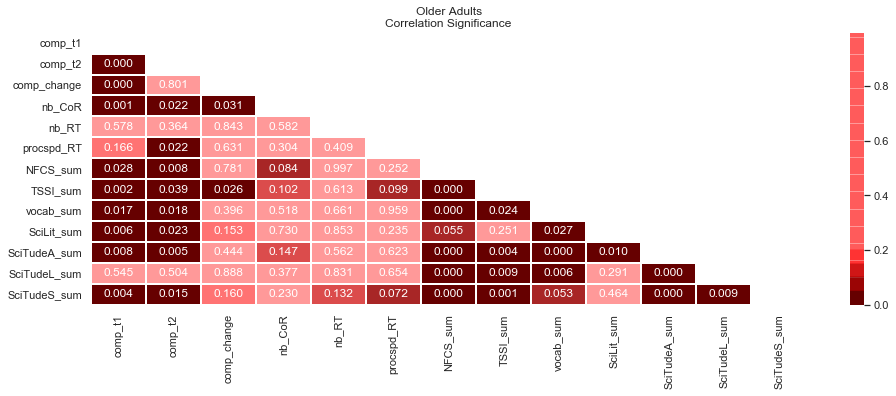

In [26]:
fig = significance_matrix(oa_sig_df,'Older Adults')
fpath = Path('..') / '..' / 'derivatives' / 'figures' / 'corr_sig_oa.png'
fig.get_figure().savefig(fpath, bbox_inches='tight')

### By Condition

In [27]:
annotated_data = slim_data[slim_data['Condition'] == 'Annotated']
original_data = slim_data[slim_data['Condition'] == 'Original']
video_data = slim_data[slim_data['Condition'] == 'Video']

In [28]:
annotated_corr_df = corr_table(annotated_data)
annotated_sig_df = sig_table(annotated_data)

original_corr_df = corr_table(original_data)
original_sig_df = sig_table(original_data)

video_corr_df = corr_table(video_data)
video_sig_df = sig_table(video_data)

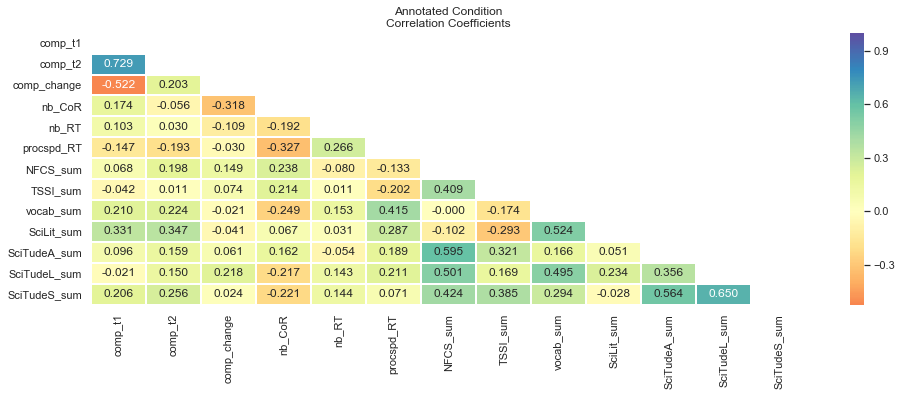

In [29]:
fig = correlation_matrix(annotated_corr_df,'Annotated Condition')
fpath = Path('..') / '..' / 'derivatives' / 'figures' / 'corr_coeff_annot.png'
fig.get_figure().savefig(fpath, bbox_inches='tight')

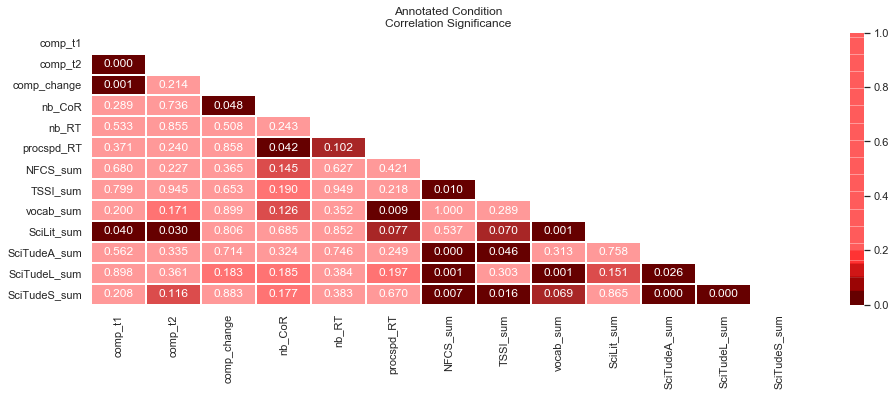

In [30]:
fig = significance_matrix(annotated_sig_df,'Annotated Condition')
fpath = Path('..') / '..' / 'derivatives' / 'figures' / 'corr_sig_annot.png'
fig.get_figure().savefig(fpath, bbox_inches='tight')

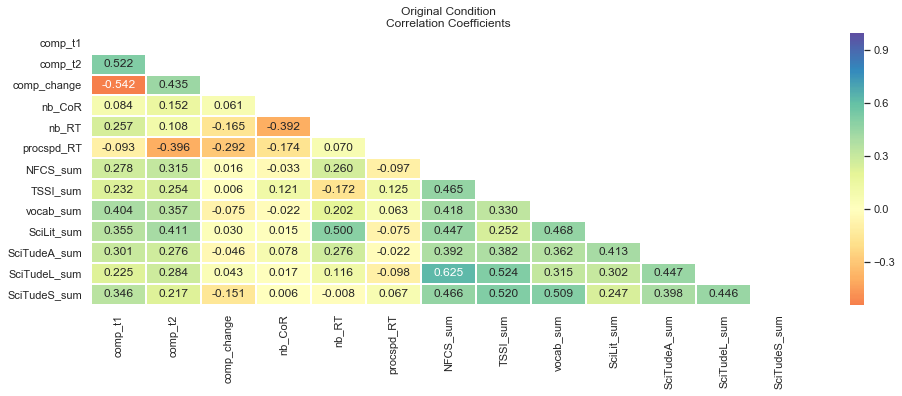

In [31]:
fig = correlation_matrix(original_corr_df,'Original Condition')
fpath = Path('..') / '..' / 'derivatives' / 'figures' / 'corr_coeff_orig.png'
fig.get_figure().savefig(fpath, bbox_inches='tight')

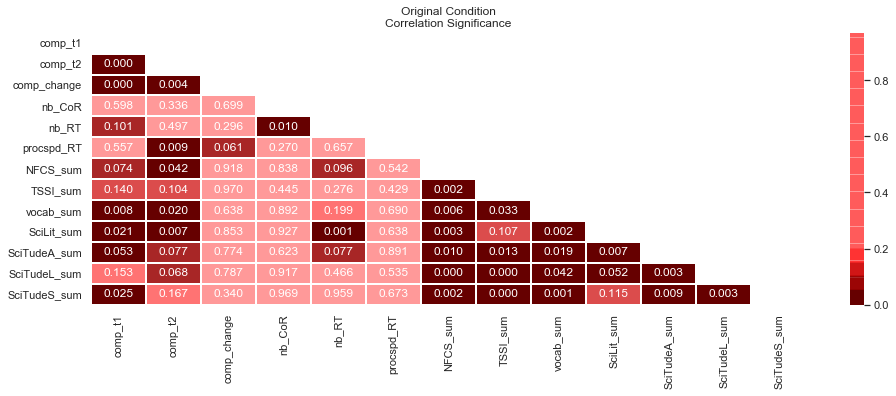

In [32]:
fig = significance_matrix(original_sig_df,'Original Condition')
fpath = Path('..') / '..' / 'derivatives' / 'figures' / 'corr_sig_orig.png'
fig.get_figure().savefig(fpath, bbox_inches='tight')

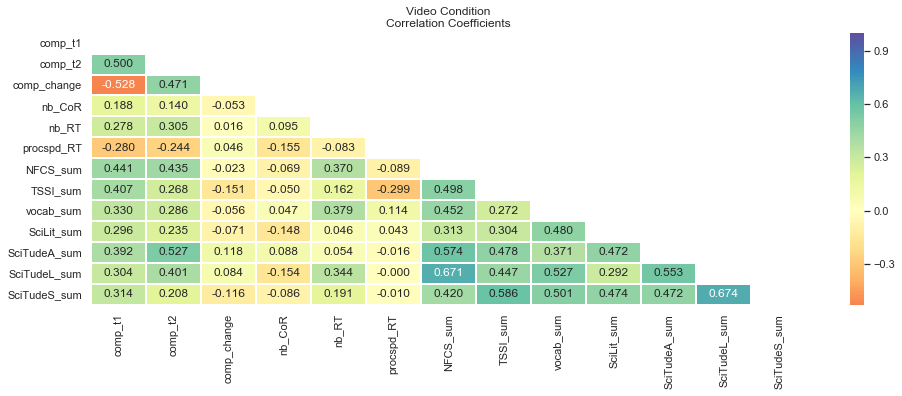

In [33]:
fig = correlation_matrix(video_corr_df,'Video Condition')
fpath = Path('..') / '..' / 'derivatives' / 'figures' / 'corr_coeff_video.png'
fig.get_figure().savefig(fpath, bbox_inches='tight')

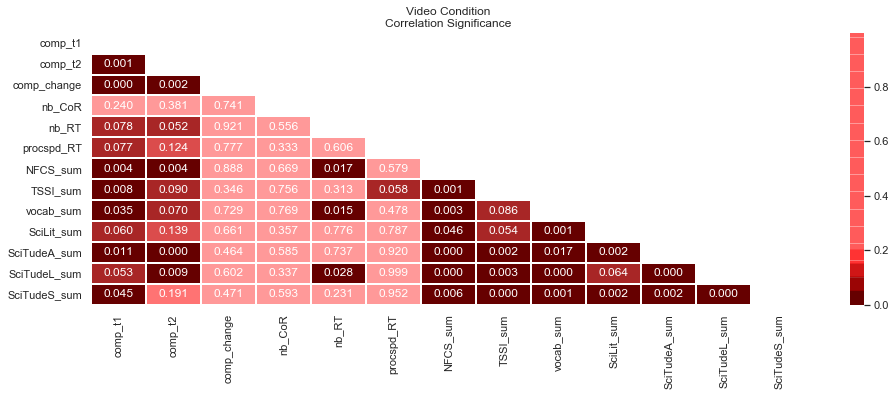

In [34]:
fig = significance_matrix(video_sig_df,'Video Condition')
fpath = Path('..') / '..' / 'derivatives' / 'figures' / 'corr_sig_video.png'
fig.get_figure().savefig(fpath, bbox_inches='tight')

## Correlograms

<Figure size 1152x360 with 0 Axes>

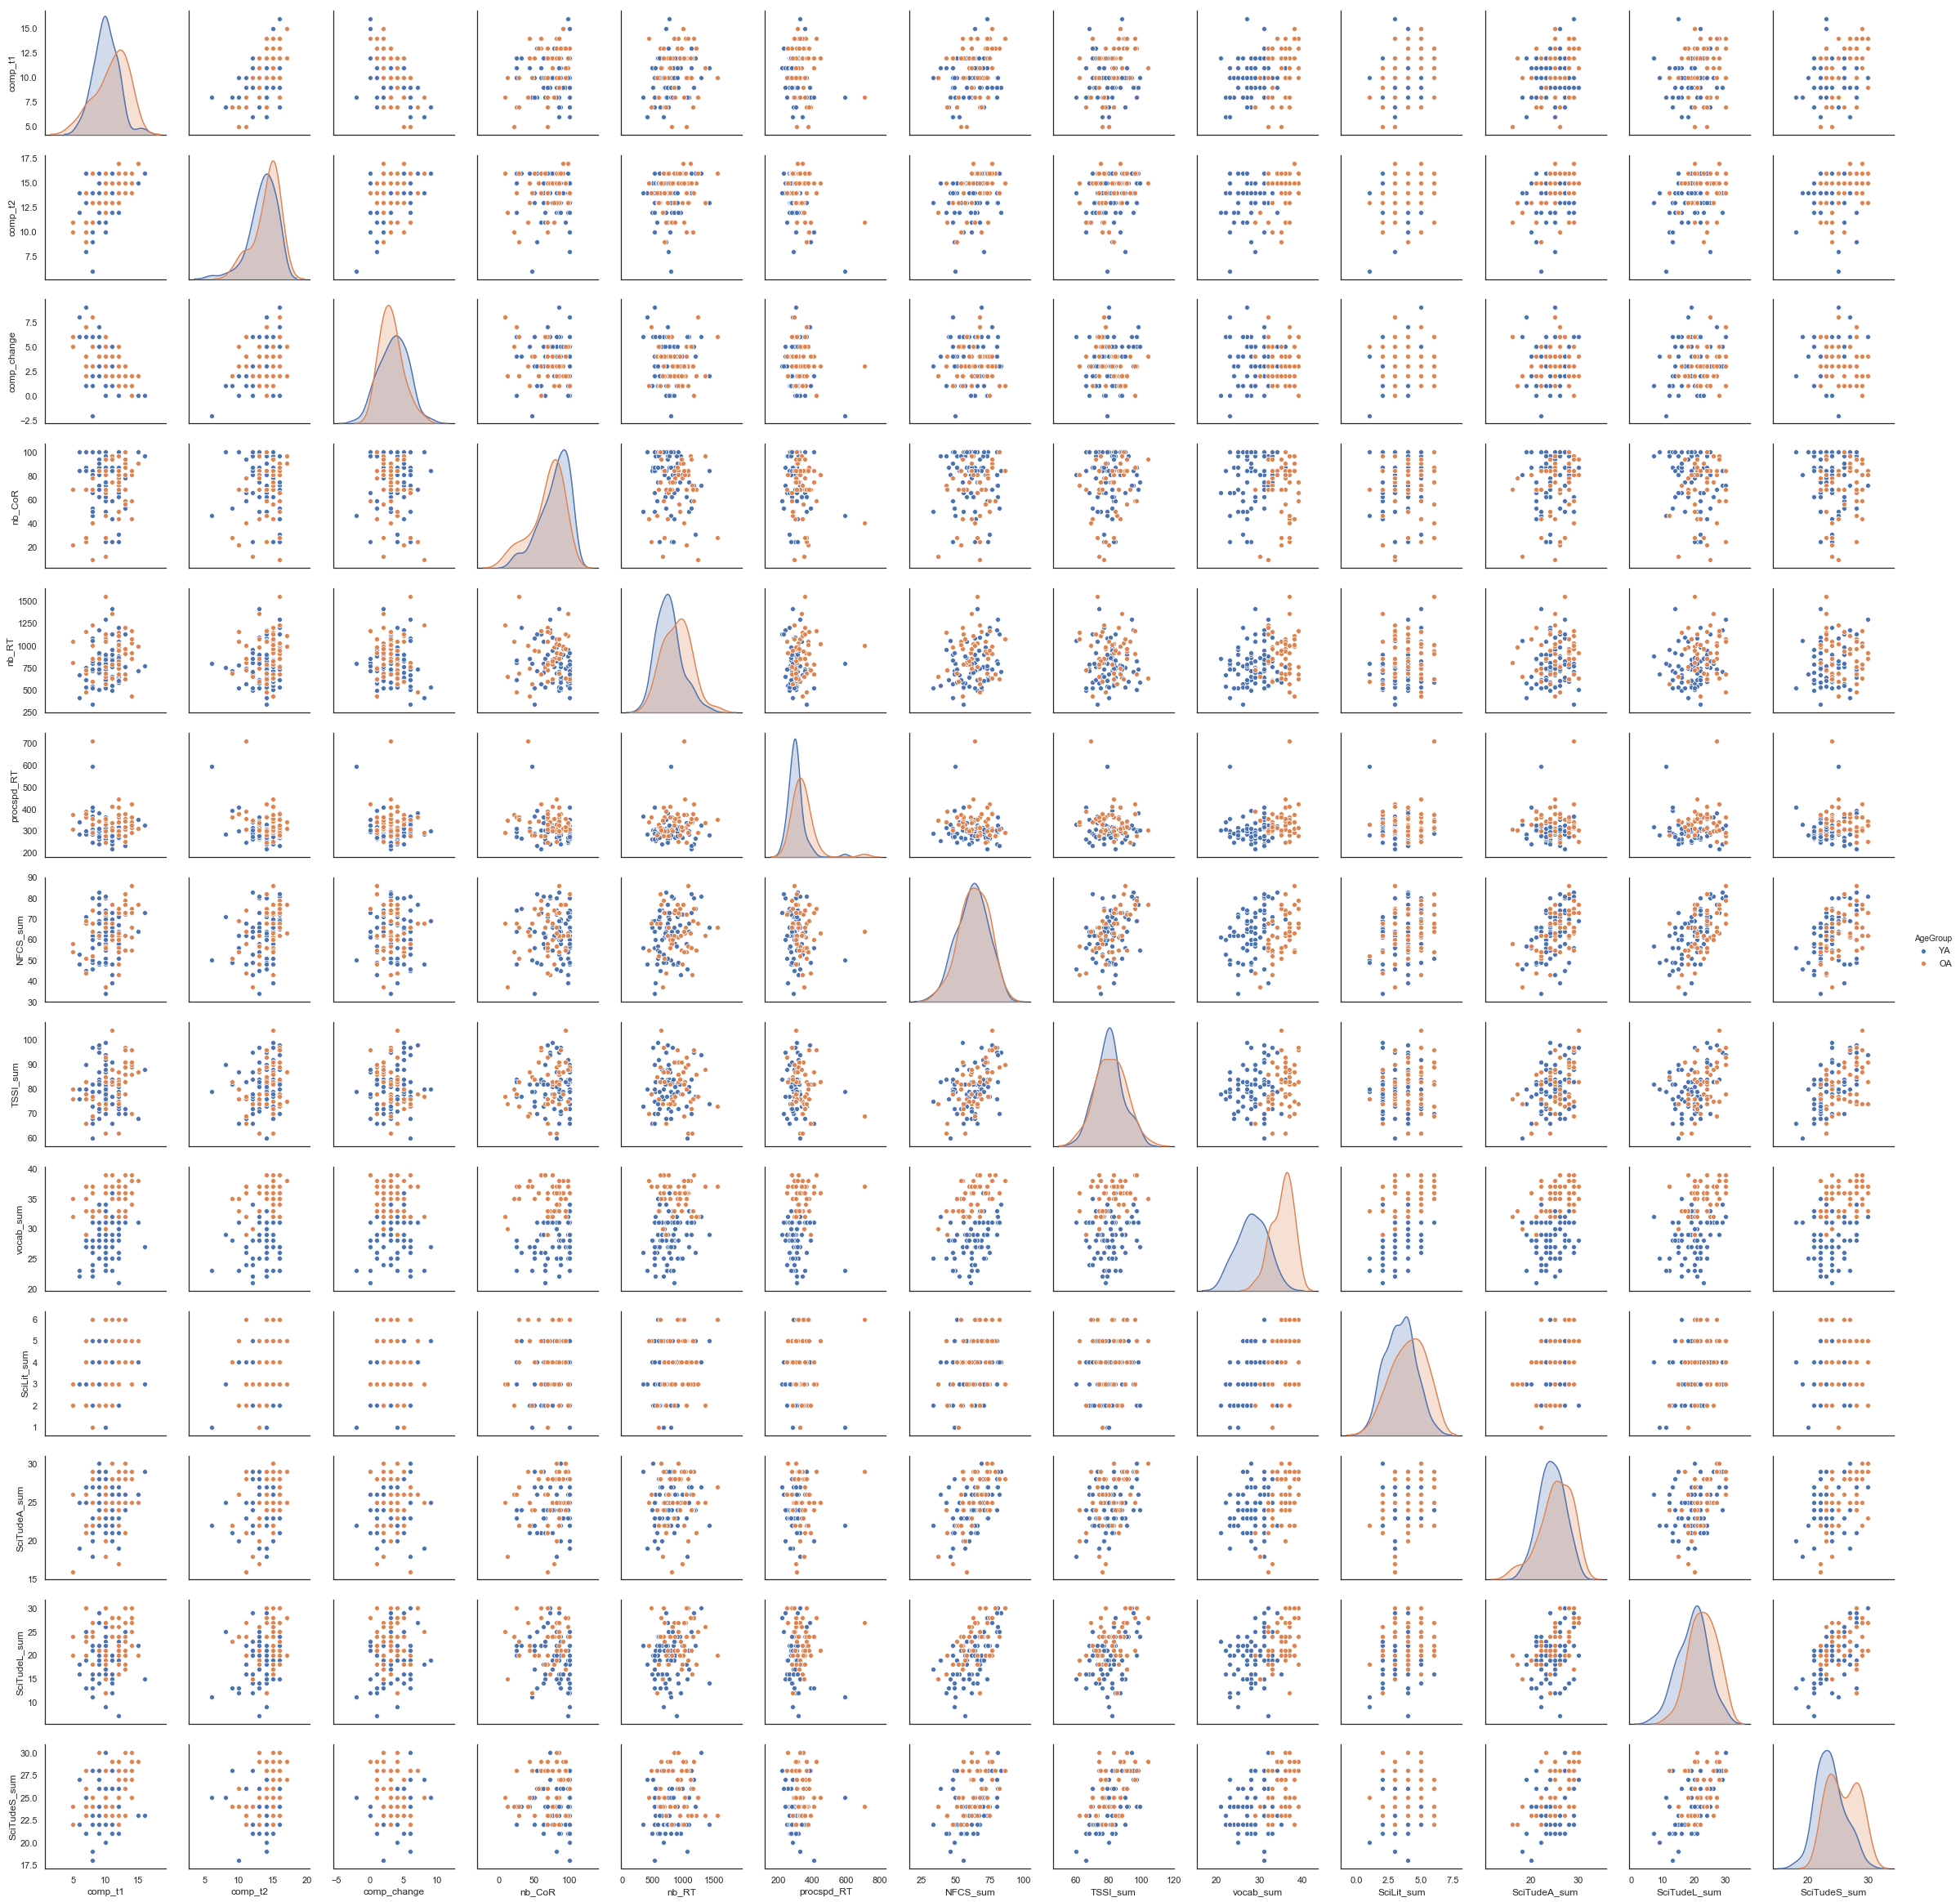

In [35]:
fpath = Path('..') / '..' / 'derivatives' / 'figures' / 'correlogram_AgeGroup.png'
plt.figure(figsize=(16,5))
df = slim_data[vars_of_interest+['AgeGroup','Condition']]
fig = sns.pairplot(df,hue='AgeGroup')
# for i,j in zip(*np.triu_indices_from(fig.axes, 1)):
#     fig.axes[i, j].set_visible(False)
fig.savefig(fpath, bbox_inches='tight')

<Figure size 1152x360 with 0 Axes>

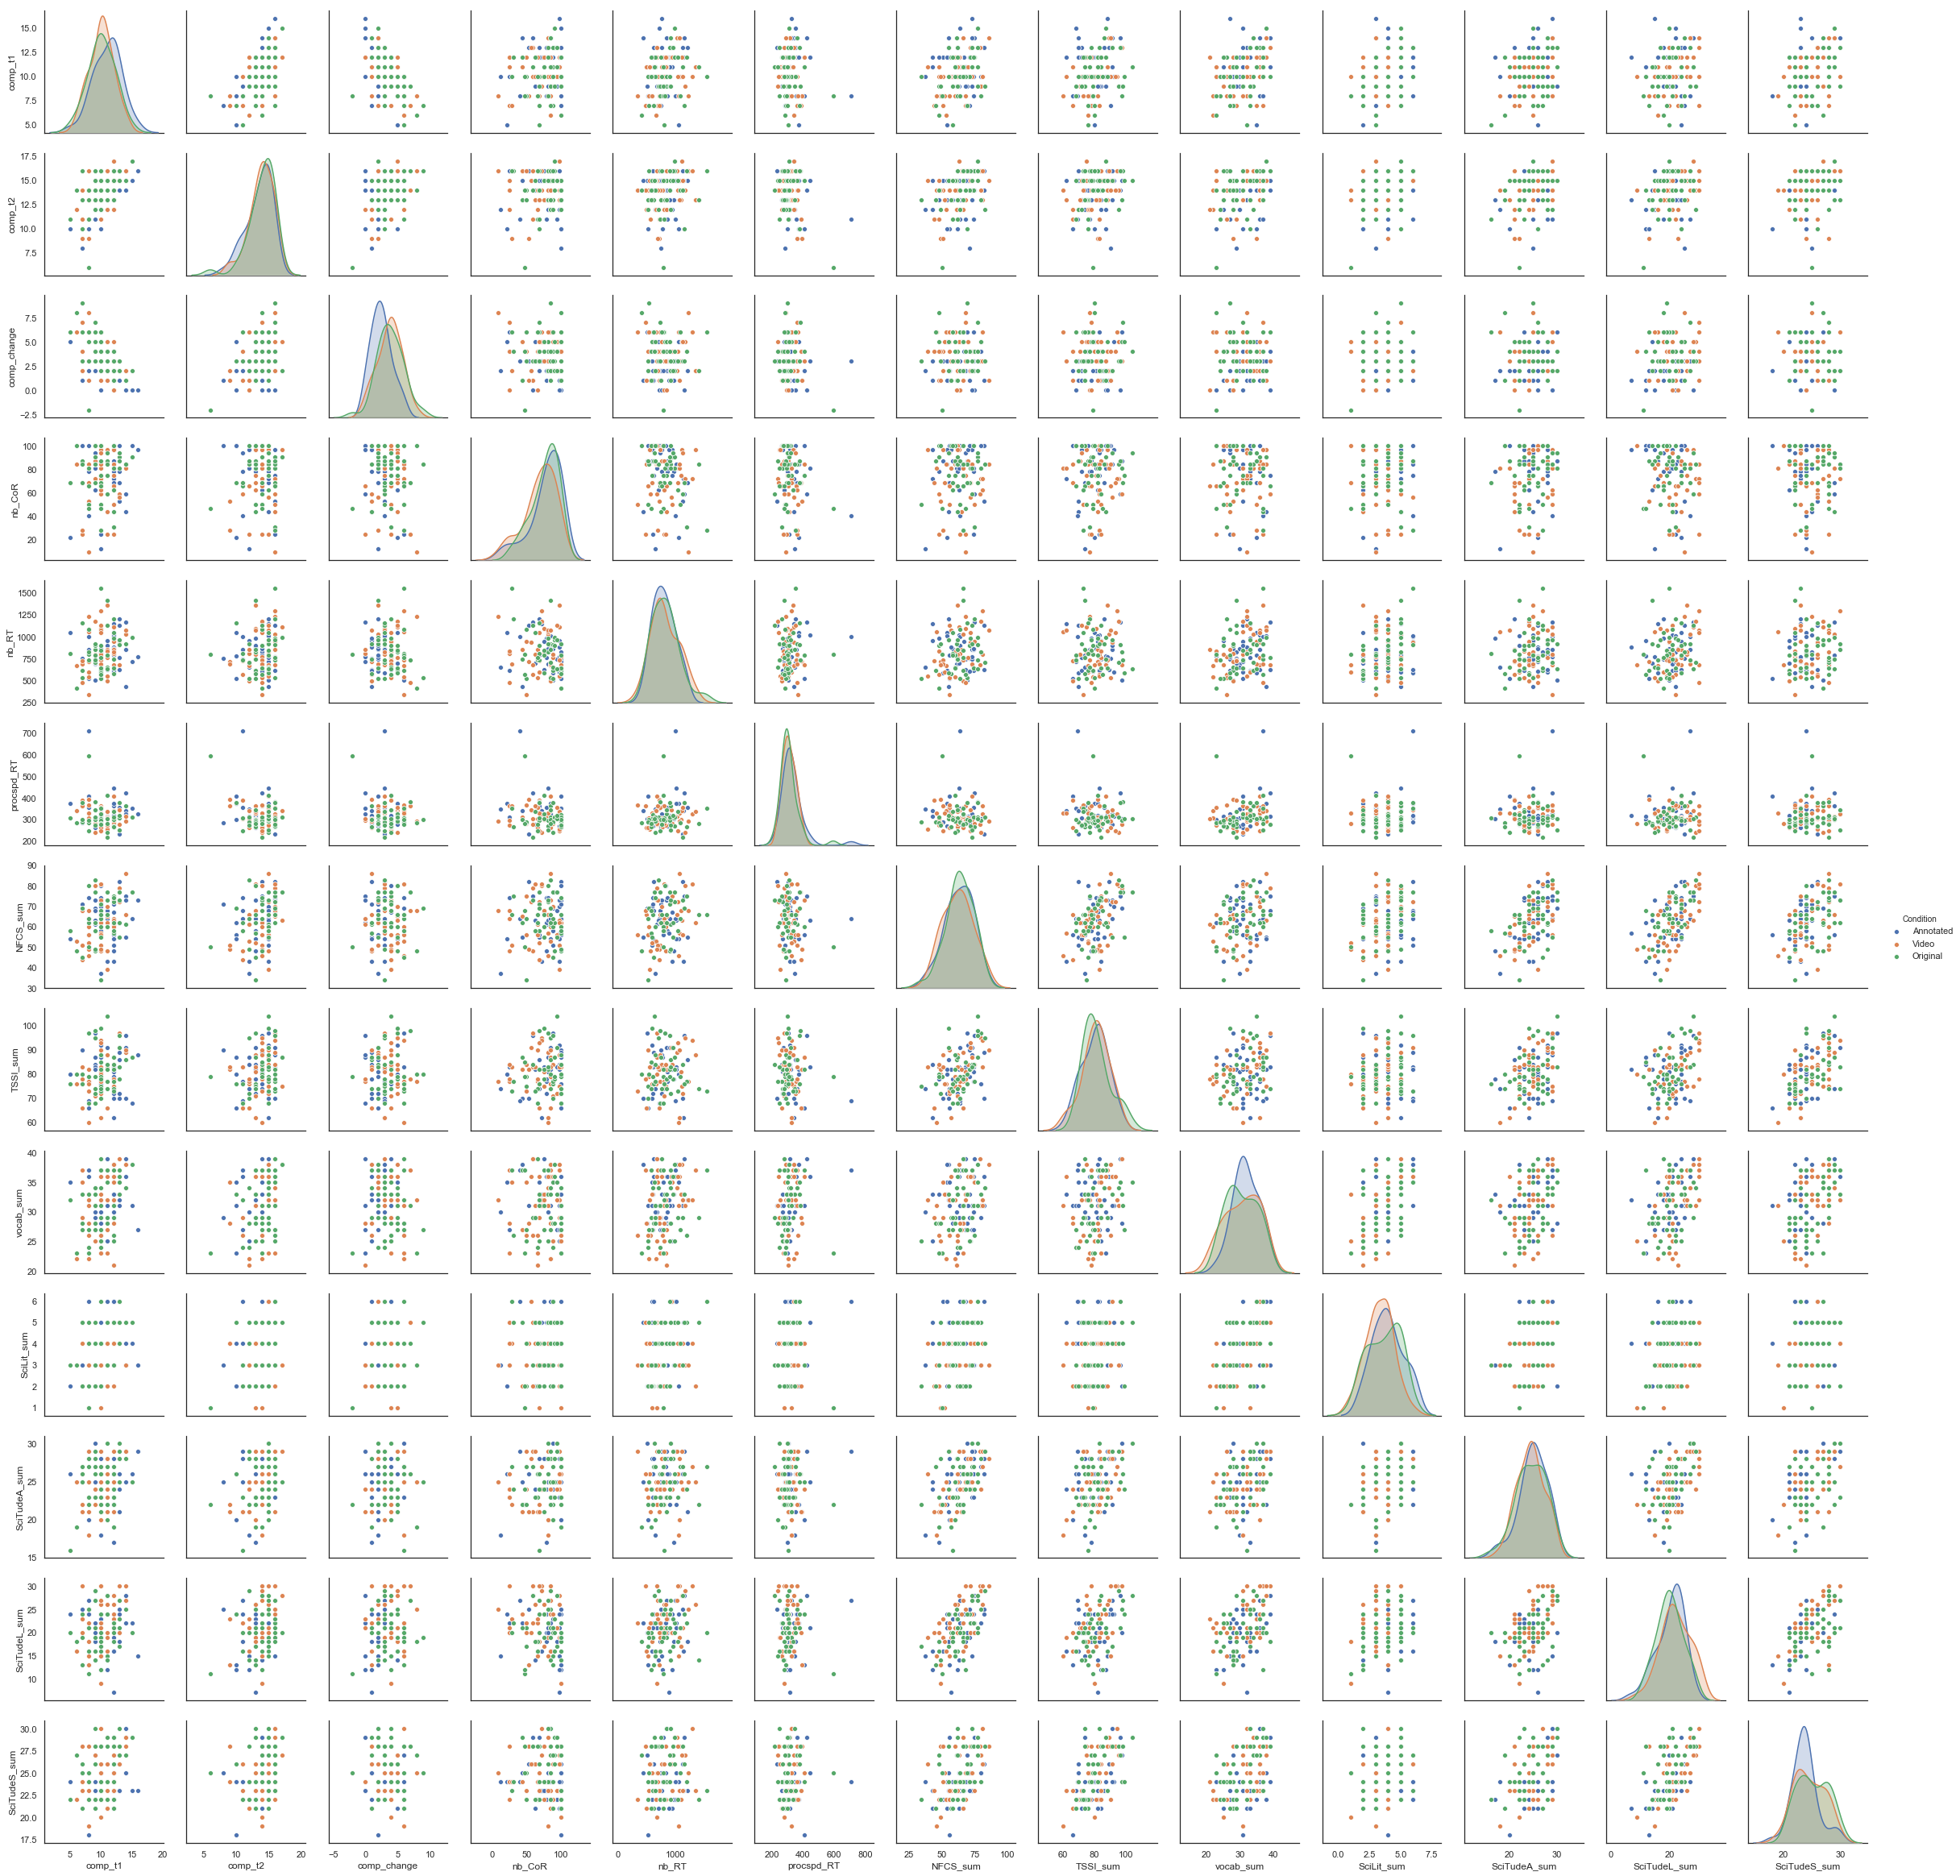

In [36]:
fpath = Path('..') / '..' / 'derivatives' / 'figures' / 'correlogram_Condition.png'
plt.figure(figsize=(16,5))
df = slim_data[vars_of_interest+['AgeGroup','Condition']]
fig = sns.pairplot(df,hue='Condition')
# for i,j in zip(*np.triu_indices_from(fig.axes, 1)):
#     fig.axes[i, j].set_visible(False)
fig.savefig(fpath, bbox_inches='tight')

## Linear Model Plots

c:\users\ia406477\appdata\local\programs\python\python37-32\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


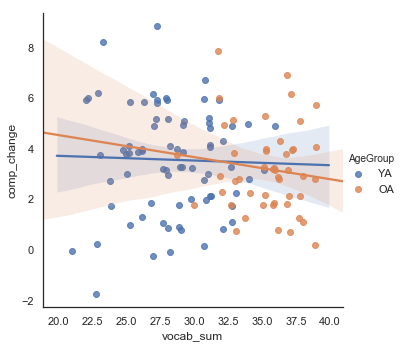

In [37]:
sns.lmplot(data=data, hue='AgeGroup',
            x='vocab_sum', x_jitter=0.3,
             y='comp_change', y_jitter=0.3)

c:\users\ia406477\appdata\local\programs\python\python37-32\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


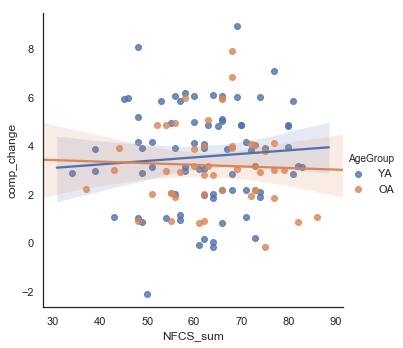

In [38]:
sns.lmplot(data=data, hue='AgeGroup',
           x='NFCS_sum',
           y='comp_change', y_jitter=0.2)

c:\users\ia406477\appdata\local\programs\python\python37-32\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


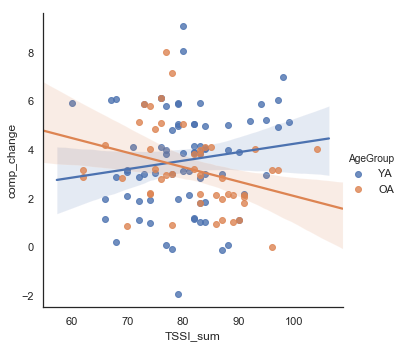

In [39]:
sns.lmplot(data=data, hue='AgeGroup',
           y='comp_change', y_jitter=0.2,
           x='TSSI_sum')

In [56]:
data['Age'].loc[data['AgeGroup'].dropna().index]

18.0    48
19.0    14
20.0     7
69.0     6
71.0     5
75.0     5
76.0     4
74.0     3
73.0     3
70.0     2
22.0     2
72.0     2
67.0     2
23.0     2
66.0     2
68.0     2
21.0     2
81.0     2
78.0     2
26.0     1
79.0     1
80.0     1
86.0     1
87.0     1
89.0     1
82.0     1
77.0     1
88.0     1
Name: Age, dtype: int64

In [45]:
sp.zscore(data['Age'].loc[data['AgeGroup']=='YA'])

array([ 0.83788846,  0.14571973, -0.54644899, -0.54644899, -0.54644899,
       -0.54644899, -0.54644899, -0.54644899, -0.54644899,  0.14571973,
        0.14571973, -0.54644899, -0.54644899,  0.83788846, -0.54644899,
       -0.54644899, -0.54644899, -0.54644899,  2.22222591, -0.54644899,
       -0.54644899, -0.54644899,  0.83788846, -0.54644899,  0.83788846,
        2.91439463, -0.54644899,  0.14571973, -0.54644899,  0.83788846,
       -0.54644899, -0.54644899,  4.99090081, -0.54644899, -0.54644899,
        0.14571973, -0.54644899, -0.54644899,  0.14571973,  2.22222591,
       -0.54644899, -0.54644899, -0.54644899, -0.54644899, -0.54644899,
        1.53005718, -0.54644899, -0.54644899,  0.14571973, -0.54644899,
       -0.54644899, -0.54644899, -0.54644899, -0.54644899,  0.14571973,
        0.14571973,  0.14571973, -0.54644899,  0.14571973, -0.54644899,
        0.14571973,  0.83788846, -0.54644899, -0.54644899, -0.54644899,
        0.14571973,  0.14571973, -0.54644899, -0.54644899,  2.91

# Horizontal Swarm, Strip, Box, Bar plots

..\..\derivatives\figures\comp_t1_Condition_swarm
..\..\derivatives\figures\comp_t2_Condition_swarm
..\..\derivatives\figures\comp_change_Condition_swarm
..\..\derivatives\figures\nb_CoR_Condition_swarm
..\..\derivatives\figures\nb_RT_Condition_swarm
..\..\derivatives\figures\procspd_RT_Condition_swarm
..\..\derivatives\figures\NFCS_sum_Condition_swarm
..\..\derivatives\figures\TSSI_sum_Condition_swarm
..\..\derivatives\figures\vocab_sum_Condition_swarm
..\..\derivatives\figures\SciLit_sum_Condition_swarm
..\..\derivatives\figures\SciTudeA_sum_Condition_swarm
..\..\derivatives\figures\SciTudeL_sum_Condition_swarm
..\..\derivatives\figures\SciTudeS_sum_Condition_swarm
..\..\derivatives\figures\comp_t1_AgeGroup_swarm
..\..\derivatives\figures\comp_t2_AgeGroup_swarm
..\..\derivatives\figures\comp_change_AgeGroup_swarm
..\..\derivatives\figures\nb_CoR_AgeGroup_swarm
..\..\derivatives\figures\nb_RT_AgeGroup_swarm
..\..\derivatives\figures\procspd_RT_AgeGroup_swarm
..\..\derivatives\figures\

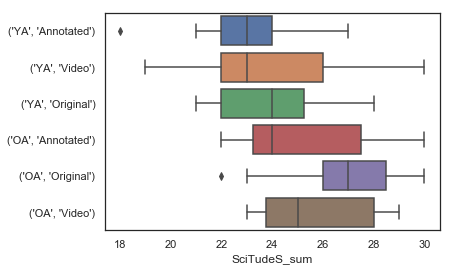

In [48]:
plot_types = { 'swarm':sns.swarmplot, 'box':sns.boxplot }
for p in plot_types.keys():
    for grp in grps_of_interest:
        for var in vars_of_interest:
            try: fig.clear()
            except AttributeError as e: fig=None
            
            fname = var +'_'+ ''.join(grp) +'_'+ p
            fpath = Path('..') / '..' / 'derivatives' / 'figures' / fname
            print(fpath)
            
            df = slim_data.set_index(grp)
            fig = plot_types[p](x=var, y=df.index, data=df)
            fig.get_figure().savefig(fpath, bbox_inches='tight')